# Exploring a `SegmentDataset` object created on the set of 192 replays from RLCS Worlds 2024

In [14]:
# Imports
from impulse import ReplayDataset
from impulse.preprocessing import SegmentedDataset
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
project_root = Path('/Users/david/dev/impulse')
data_dir = project_root / 'replays' / 'parsed'
db_path = project_root / 'impulse.db'

replay_dataset = ReplayDataset(db_path=str(db_path), data_dir=str(data_dir))

In [5]:
segmented_dataset = SegmentedDataset(replay_dataset, seed=42)

Found 192 parsed replays in database


In [12]:
train_segments = segmented_dataset.train_segments_list()
len(train_segments)

618

In [10]:
type(train_segments[0])

impulse.preprocessing.segmentation.ReplaySegment

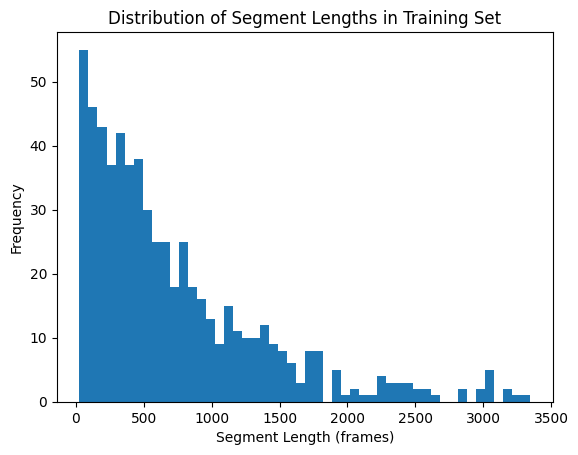

In [11]:
segment_lengths = [len(segment.frames) for segment in train_segments]

plt.hist(segment_lengths, bins=50)
plt.xlabel('Segment Length (frames)')
plt.ylabel('Frequency')
plt.title('Distribution of Segment Lengths in Training Set')
plt.show()

In [ ]:
print('Segment length mean:', np.mean(segment_lengths))
print('Segment length median:', np.median(segment_lengths))
print('Segment length min:', np.min(segment_lengths))
print('Segment length max:', np.max(segment_lengths))

Segment length mean: 724.6472491909385
Segment length median: 518.5
Segment length min: 26
Segment length max: 3348


Let's cut out any segments shorter than 3 seconds or longer than 5 minutes. Since the dataset was parsed at 10 FPS, this corresponds to excluding segments shorter than 30 frames or longer than 3000 frames. 

In [22]:
print('Number of training segments before filtering:', len(train_segments))
filtered_train_segments = [segment for segment in train_segments if 30 <= len(segment) <= 3000]
print('Number of training segments after filtering:', len(filtered_train_segments))

Number of training segments before filtering: 618
Number of training segments after filtering: 605


In [23]:
for seg in filtered_train_segments:
    seg.frames.dropna(axis=1, how='all', inplace=True)